# Bidirectional RNN for PTB dataset

The goal of this notebook is to try out different Bidirectional RNN architectures on a PTB Diagnostic ECG Database: https://www.physionet.org/content/ptbdb/1.0.0/  

The data was downloaded from kaggle: https://www.kaggle.com/shayanfazeli/heartbeat

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, \
accuracy_score, f1_score, roc_curve, precision_recall_curve, \
roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from keras.engine.saving import load_model
from keras import backend as K

Using TensorFlow backend.


## Read the data

In [2]:
data_path_normal =  "../input/ptbdb_normal.csv"
data_path_abnormal = "../input/ptbdb_abnormal.csv"

In [3]:
timepoints_per_sample = 187
df_1 = pd.read_csv(data_path_normal, header=None)
df_2 = pd.read_csv(data_path_abnormal, header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

X_bl = np.array(df_train[list(range(187))].values)[..., np.newaxis]
X_test_bl = np.array(df_test[list(range(187))].values)[..., np.newaxis]

# normalize without taking the zero-padding at the end into account:
for sample_idx in range(X.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X[sample_idx, 0: first_zero_sample, 0] -= np.mean(X[sample_idx, 0: first_zero_sample, 0])
    X[sample_idx, 0: first_zero_sample, 0] /= np.std(X[sample_idx, 0: first_zero_sample, 0])

for sample_idx in range(X_test.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X_test[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X_test[sample_idx, 0: first_zero_sample, 0] -= np.mean(X_test[sample_idx, 0: first_zero_sample, 0])
    X_test[sample_idx, 0: first_zero_sample, 0] /= np.std(X_test[sample_idx, 0: first_zero_sample, 0])

We have experimented with three architectures:

1. *bidir_default*:  Bidirectional LSTM layer + Dropout + 2 Dense layers
2. *bidir_gru_default*:   Bidirectional GRU layer + Dropout + 2 Dense layers
3. *bidir_double_default*:   Bidirectional LSTM layer + Dropout + Bidirectional LSTM layer + Dropout + Dense layer

The first model take a reasonable time to train and produced promising results. We have tried to further improve it by performing a naive hyperparameter tuning. We have experimented with different combinations of a) number of LSTM units b) number of dense units

The results of these experiments were saved in the following files:


1. 'bidirect_gru_ptbdb.h5'
2. 'bidirect_bidir_lstm_ptbdb.h5'
3. 'bidir_default_units_bidir_64_units_dense_64.h5'
4. 'bidir_default_units_bidir_64_units_dense_32.h5'
5. 'bidir_default_units_bidir_128_units_dense_32.h5'
6. 'bidir_default_units_bidir_32_units_dense_64.h5'
7. 'bidir_default_units_bidir_32_units_dense_128.h5'


**NB:** Names 4. - 7. obey the following convention: (model name)_units_bidir_(number of LSTM units)_units_dense_(number of dense units)

## Load and visualize fitted models:

In [4]:
double_bidir_lstm_ptbdb        = \
load_model('../saved_trained_models/rnn_experiments/bidirect_bidir_lstm_ptbdb.h5')

gru_ptbdb                      = \
load_model('../saved_trained_models/rnn_experiments/bidirect_gru_ptbdb.h5')

units_bidir_64_units_dense_64  = \
load_model('../saved_trained_models/rnn_experiments/bidir_default_units_bidir_64_units_dense_64.h5')

units_bidir_64_units_dense_32  = \
load_model('../saved_trained_models/rnn_experiments/bidir_default_units_bidir_64_units_dense_32.h5')

units_bidir_128_units_dense_32 = \
load_model('../saved_trained_models/rnn_experiments/bidir_default_units_bidir_128_units_dense_32.h5')

units_bidir_32_units_dense_64  = \
load_model('../saved_trained_models/rnn_experiments/bidir_default_units_bidir_32_units_dense_64.h5')

units_bidir_32_units_dense_128 = \
load_model('../saved_trained_models/rnn_experiments/bidir_default_units_bidir_32_units_dense_128.h5')

# load baseline model
baseline_model = load_model("../saved_trained_models/baseline_cnn_ptb.h5")

## **Model Comparison**

We contrast all trained models using three characteristis:

1. **ROC curve**
2. **Accuracy score**
3. **F1 score**

In [5]:
def prepare_roc_input(keras_model, X_test, Y_test, plot_roc=True):
    
    y_pred_keras = keras_model.predict(X_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
    auc_keras = roc_auc_score(Y_test, y_pred_keras)

    return fpr_keras, tpr_keras, auc_keras

In [6]:
fpr_gru_ptbdb, tpr_gru_ptbdb, auc_gru_ptbdb = \
prepare_roc_input(gru_ptbdb, X_test, Y_test, plot_roc=False)
fpr_double_bidir, tpr_double_bidir, auc_double_bidir = \
prepare_roc_input(double_bidir_lstm_ptbdb, X_test, Y_test, plot_roc=False)
fpr_64_64, tpr_64_64, auc_64_64 = \
prepare_roc_input(units_bidir_64_units_dense_64, X_test, Y_test, plot_roc=False)
fpr_64_32, tpr_64_32, auc_64_32 = \
prepare_roc_input(units_bidir_64_units_dense_32, X_test, Y_test, plot_roc=False)
fpr_128_32, tpr_128_32, auc_128_32 = \
prepare_roc_input(units_bidir_128_units_dense_32, X_test, Y_test, plot_roc=False)
fpr_32_64, tpr_32_64, auc_32_64 = \
prepare_roc_input(units_bidir_32_units_dense_64, X_test, Y_test, plot_roc=False)
fpr_32_128, tpr_32_128, auc_32_128 = \
prepare_roc_input(units_bidir_32_units_dense_128, X_test, Y_test, plot_roc=False)

# baseline
fpr_bl, tpr_bl, auc_bl = prepare_roc_input(baseline_model, X_test=X_test_bl, Y_test=Y_test, plot_roc=False)

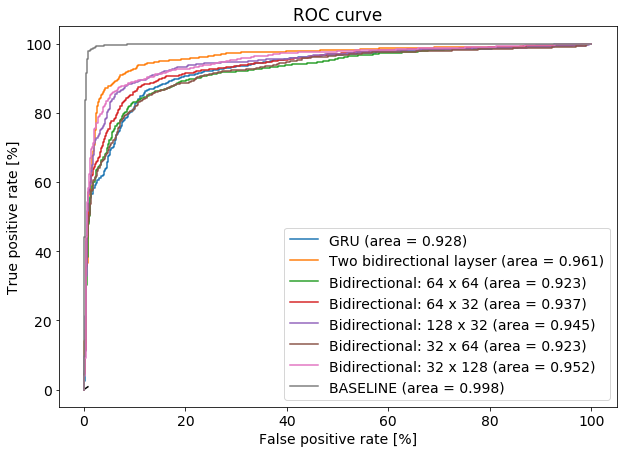

In [7]:
matplotlib.rcParams.update({'font.size': 14})
plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')


plt.plot(100*fpr_gru_ptbdb, 100*tpr_gru_ptbdb, label='GRU (area = {:.3f})'.format(auc_gru_ptbdb))
plt.plot(100*fpr_double_bidir, 100*tpr_double_bidir, label='Two bidirectional layser (area = {:.3f})'\
         .format(auc_double_bidir))
plt.plot(100*fpr_64_64, 100*tpr_64_64, label='Bidirectional: 64 x 64 (area = {:.3f})'.format(auc_64_64))
plt.plot(100*fpr_64_32, 100*tpr_64_32, label='Bidirectional: 64 x 32 (area = {:.3f})'.format(auc_64_32))
plt.plot(100*fpr_128_32, 100*tpr_128_32, label='Bidirectional: 128 x 32 (area = {:.3f})'.format(auc_128_32))
plt.plot(100*fpr_32_64, 100*tpr_32_64, label='Bidirectional: 32 x 64 (area = {:.3f})'.format(auc_32_64))
plt.plot(100*fpr_32_128, 100*tpr_32_128, label='Bidirectional: 32 x 128 (area = {:.3f})'.format(auc_32_128))
plt.plot(100*fpr_bl, 100*tpr_bl, label='BASELINE (area = {:.3f})'.format(auc_bl))


plt.xlabel('False positive rate [%]')
plt.ylabel('True positive rate [%]')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Compute **accuracy** and **f1 score** of the classification models

In [8]:
def evaluate_model_short(model, X_test, Y_test, verbose=False ):

    pred_test = model.predict(X_test)
    pred_test = (pred_test > 0.5).astype(np.int8)

    f1 = f1_score(Y_test, pred_test)

    if(verbose):
        print("Test f1 score : %s " % f1)

    acc = accuracy_score(Y_test, pred_test)

    if(verbose):
        print("Test accuracy score : %s " % acc)

    result = {"accuracy": acc, "f1": f1}
    return result

In [9]:
eval_gru_ptbdb  = evaluate_model_short(gru_ptbdb, X_test=X_test, Y_test=Y_test)
eval_double_bidir_lstm_ptbdb = evaluate_model_short(double_bidir_lstm_ptbdb, X_test=X_test, Y_test=Y_test)

eval_units_bidir_64_units_dense_64 = \
evaluate_model_short(units_bidir_64_units_dense_64, X_test=X_test, Y_test=Y_test)

eval_units_bidir_64_units_dense_32 = \
evaluate_model_short(units_bidir_64_units_dense_32, X_test=X_test, Y_test=Y_test)

eval_units_bidir_128_units_dense_32 = \
evaluate_model_short(units_bidir_128_units_dense_32, X_test=X_test, Y_test=Y_test)

eval_units_bidir_32_units_dense_64 = \
evaluate_model_short(units_bidir_32_units_dense_64, X_test=X_test, Y_test=Y_test)

eval_units_bidir_32_units_dense_128 = \
evaluate_model_short(units_bidir_32_units_dense_128, X_test=X_test, Y_test=Y_test)

# BASELINE
eval_baseline  = evaluate_model_short(baseline_model, X_test=X_test_bl, Y_test=Y_test)

In [10]:
eval_stats = pd.DataFrame({"model":[ "Baseline","GRU", "Two\nbidirectional\nlayers", "Bidirectional:\n64 x 64",
                                    "Bidirectional:\n64 x 32", "Bidirectional:\n128 x 32",
                                    "Bidirectional:\n32 x 64", "Bidirectional:\n32 x 128"], 
                           
                          "accuracy":[eval_baseline['accuracy'], eval_gru_ptbdb['accuracy'], 
                                      eval_double_bidir_lstm_ptbdb['accuracy'], 
                                      eval_units_bidir_64_units_dense_64['accuracy'], 
                                      eval_units_bidir_64_units_dense_32['accuracy'],
                                      eval_units_bidir_128_units_dense_32['accuracy'], 
                                      eval_units_bidir_32_units_dense_64['accuracy'],
                                      eval_units_bidir_32_units_dense_128['accuracy']], 
                           
                          "f1_score":[eval_baseline['f1'], eval_gru_ptbdb['f1'],
                                      eval_double_bidir_lstm_ptbdb['f1'], 
                                      eval_units_bidir_64_units_dense_64['f1'], 
                                      eval_units_bidir_64_units_dense_32['f1'],
                                      eval_units_bidir_128_units_dense_32['f1'], 
                                      eval_units_bidir_32_units_dense_64['f1'],
                                      eval_units_bidir_32_units_dense_128['f1']]})


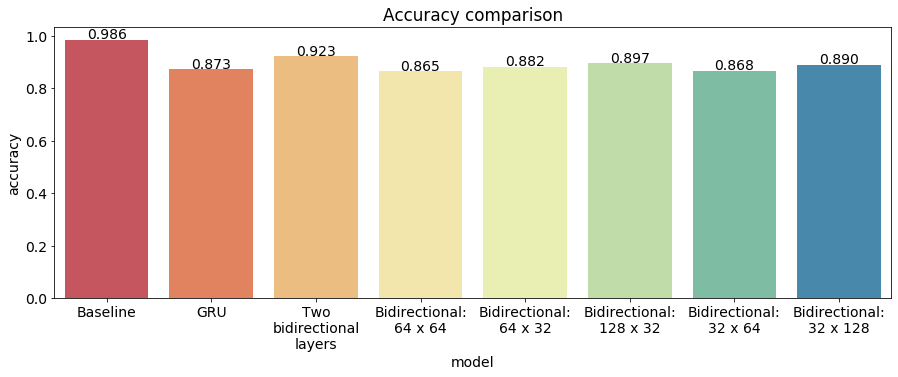

In [11]:
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(15, 5))

splot = sns.barplot(x="model", y="accuracy", data=eval_stats, palette="Spectral")
plt.title("Accuracy comparison")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show()


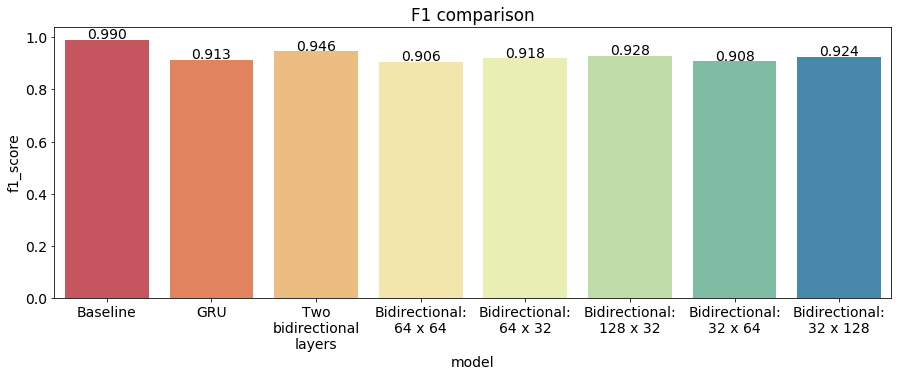

In [12]:
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(15, 5))

matplotlib.rcParams.update({'font.size': 14})

splot = sns.barplot(x="model", y="f1_score", data=eval_stats, palette="Spectral")
plt.title("F1 comparison")

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show()


## **CONCLUSION**


None of our bidirectional rnn models was able to outperform the baseline model. Among our models, a network with two bidirectional layers produced the best results with respect to all examined criteria. This network also required more training time. The second best performance was demonstrated by a Bidirectional Lstm network with 128 hidden units and 32 Dense units.



Confusion matrix to summarize model performance on the test set.

<Figure size 576x576 with 0 Axes>

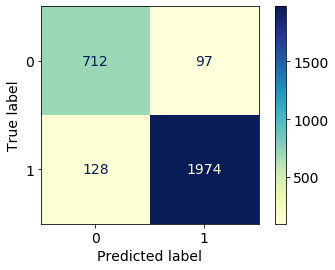

In [14]:
plt.figure(1, figsize=(8, 8))

model = double_bidir_lstm_ptbdb
pred_test = model.predict(X_test)
pred_test = (pred_test > 0.5).astype(np.int8)

ConfusionMatrixDisplay(confusion_matrix(Y_test, pred_test), 
                       display_labels = ["0","1"]).plot(values_format="d", cmap='YlGnBu')

plt.show()

We plot the t-SNE plots of representations learned by subsequent layers.

In [15]:
def get_ith_layer_output(i, model):
    if i > len(model.layers)-1:
      print("i exceeds the number of the layers in the network")
      raise Exception
    return K.function([model.layers[0].input],[model.layers[i].output])


layer_1 = get_ith_layer_output(model=double_bidir_lstm_ptbdb, i=1)([X])[0]
layer_2 = get_ith_layer_output(model=double_bidir_lstm_ptbdb, i=2)([X])[0]
layer_3 = get_ith_layer_output(model=double_bidir_lstm_ptbdb, i=3)([X])[0]
layer_4 = get_ith_layer_output(model=double_bidir_lstm_ptbdb, i=3)([X])[0]

In [16]:
X_tsne = TSNE(n_components=2, perplexity=50, random_state=1337).fit_transform(X[ :, :,0])
layer_2_tsne = TSNE(n_components=2, perplexity=50, random_state=1337).fit_transform(layer_2)
layer_3_tsne = TSNE(n_components=2, perplexity=50, random_state=1337).fit_transform(layer_3)
layer_4_tsne = TSNE(n_components=2, perplexity=50, random_state=1337).fit_transform(layer_4)

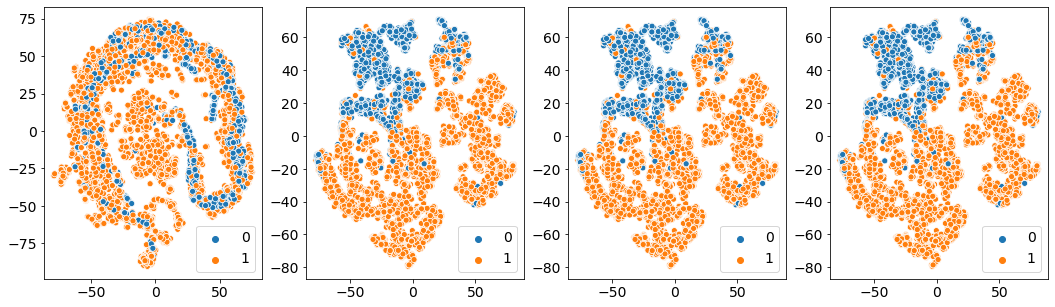

In [17]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 4, 1)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=Y)

plt.subplot(1, 4, 2)
sns.scatterplot(x=layer_2_tsne[:,0], y=layer_2_tsne[:,1], hue=Y)

plt.subplot(1, 4, 3)
sns.scatterplot(x=layer_3_tsne[:,0], y=layer_3_tsne[:,1], hue=Y)

plt.subplot(1, 4, 4)
sns.scatterplot(x=layer_4_tsne[:,0], y=layer_4_tsne[:,1], hue=Y)
plt.show()

The plots suggest that the network learns useful features that distinguish between the two classes.